# Review Addressor Agent

Review addressor agent is used to address reviews left by reviewers. It will start by distinguishing if the comments are: 
 1. Requests to change the code;
 2. Just feedback and define the next steps to follow. 

If there are changes to be made, the agent will plan and execute the next steps.
If the comments are just feedback, the agent will reply to the reviewer with contextualized responses.

## Setup

First we need to import the agent and ensure the following already exists:
 - A repository on GitLab local instance [http://127.0.0.1:8929](http://127.0.0.1:8929);
 - A merge request with changes on that repository.

After all set, replace: 
 - `source_repo_id` with the id of your repository;
 - `source_ref` with the branch name of created merge request


In [1]:
from langgraph.store.memory import InMemoryStore
from rich import print  # noqa: A004

from automation.agents.review_addressor import ReviewAddressorAgent

source_repo_id = "dipcode/django-webhooks"
source_ref = "fix/typo-readme-1"

config = {"run_name": "ReviewAddressor", "configurable": {"source_repo_id": source_repo_id, "source_ref": source_ref}}
store = InMemoryStore()

review_addressor = ReviewAddressorAgent(store=store)

## Graph

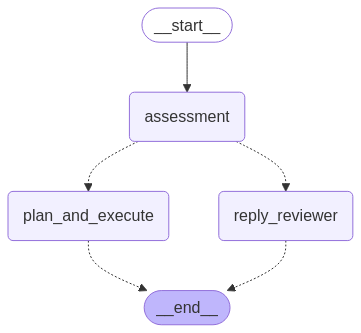

In [2]:
from IPython.display import Image, display  # noqa: A004

display(Image(review_addressor.draw_mermaid()))

## Example
Here are examples of the review addressor agent in action. 

### Reply to inline comment

Let's say we left a comment inline. The diff will only include the commented line.

The expected behavior is that the agent will reply to the comment with a contextualized response, by calling the appropriate tools and using the diff hunk to extract the relevant information.

Let's see the agent in action:

In [3]:
diff = "--- a/README.md\n+++ b/README.md\n@@ -11,1 +11,1 @@\n   - [Development](#development)\n"
notes = [{"role": "user", "content": "Confirm that the link is updated with the section title below?"}]

result = review_addressor.agent.invoke({"diff": diff, "notes": notes}, config=config)

In [4]:
print(result["reply"])

Yes, the link for the "Development" section is correctly updated and matches the section title in the document. The
anchor link `#development` is properly formatted and points to the correct section in the README.

In [ ]:
# To see all messages in the conversation, you can use the following code:
for message in result["messages"]:
    print(message.pretty_print())

Now let's see the agent behavior when i reply to him:

In [5]:
notes += [{"role": "assistant", "content": result["reply"]}, {"role": "user", "content": "Thank you!"}]

result = review_addressor.agent.invoke({"diff": diff, "notes": notes}, config=config)

In [6]:
print(result["reply"])

You're welcome! I'm glad I could help confirm the section link.

In [ ]:
# To see all messages in the conversation, you can use the following code:
for message in result["messages"]:
    print(message.pretty_print())

### Reply to file comment

Let's say we left a comment on a file. The diff will include the whole file.

The expected behavior is that the agent will reply to the comment considering the diff hunk with all the changes made on that file.


In [3]:
diff = """--- a/README.md
+++ b/README.md
@@ -10,7 +10,7 @@ Django Webhooks is a Python package that provides a convenient way to handle web
   - [Usage](#usage)
   - [Development](#development)
     - [Running tests](#running-tests)
-    - [Usefull commands](#usefull-commands)
+    - [Useful commands](#useful-commands)
   - [Update the package version](#update-the-package-version)

 ## Installation
@@ -82,7 +82,7 @@ $ pipenv run lint-format

 ```

-### Usefull commands
+### Useful commands

 The project includes a `Makefile` to help you in some tasks listed below:
"""

notes = [{"role": "user", "content": "Do a review of the changes made here"}]

result = review_addressor.agent.invoke({"diff": diff, "notes": notes}, config=config)

In [4]:
print(result["reply"])

I've corrected the spelling of "Usefull" to "Useful" in both the table of contents and section heading. This 
improves the documentation's readability without changing any functionality.

In [ ]:
# To see all messages in the conversation, you can use the following code:
for message in result["messages"]:
    print(message.pretty_print())

### Reply to merge request comment

Let's say we have left a comment on the merge request. The diff will include the whole merge request.

The expected behavior is that the agent will reply to the comment considering the diff hunk with all the changes made on that merge request.


In [5]:
diff = """--- a/CHANGELOG.md
+++ b/CHANGELOG.md
@@ -7,6 +7,11 @@ and this project adheres to [Semantic Versioning](http://semver.org/spec/v2.0.0.

 ## [Unreleased]

+### Fixed
+
+- Fixed typos in README.md documentation
+
+
 ## [0.3.2] - 2024-08-13

 ### Fixed
--- a/README.md
+++ b/README.md
@@ -10,7 +10,7 @@ Django Webhooks is a Python package that provides a convenient way to handle web
   - [Usage](#usage)
   - [Development](#development)
     - [Running tests](#running-tests)
-    - [Usefull commands](#usefull-commands)
+    - [Useful commands](#useful-commands)
   - [Update the package version](#update-the-package-version)

 ## Installation
@@ -82,7 +82,7 @@ $ pipenv run lint-format

 ```

-### Usefull commands
+### Useful commands

 The project includes a `Makefile` to help you in some tasks listed below:

"""
notes = [{"role": "user", "content": "Do the Changelog file needs to be updated?"}]

result = review_addressor.agent.invoke({"diff": diff, "notes": notes}, config=config)

In [6]:
print(result["reply"])

Yes, the Changelog has been appropriately updated with the typo fixes in the README.md documentation under the 
"[Unreleased]" section.

In [ ]:
# To see all messages in the conversation, you can use the following code:
for message in result["messages"]:
    print(message.pretty_print())

### Address inline comments

Let's say we left a comment inline that requires some changes to be made on the codebase.

The expected behavior is that the agent will address the comment by calling the plan and execute agent. This agent will plan the steps to follow and execute them without the need of human intervention.

Let's see the agent in action:

In [7]:
diff = """--- a/CHANGELOG.md
+++ b/CHANGELOG.md
@@ -12,0 +12,1 @@
+- Fixed typos in README.md documentation
"""

notes = [{"role": "user", "content": "Add a dot at the end of the phrase."}]

result = review_addressor.agent.invoke({"diff": diff, "notes": notes}, config=config)